In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys
from pathlib import Path

sys.path.append('/mnt/nas05/data01/francesco/progetto_simone/ionosphere/')
from src.data.dataset import get_sequence_data_objects, IONOSPHERE_PREPROCESS

plt.style.use('default')
%matplotlib inline

/mnt/nas05/data01/francesco/progetto_simone/ionosphere/src/vit.py:26: FutureWarning: xformers.components is deprecated and is not maintained anymore. It might be removed in a future version of xFormers 
  import xformers.components.attention.core as xfa


# Test IonoSequenceDataset with New Preprocessing

This notebook tests the new SDO-style preprocessing integrated into `IonoSequenceDataset`.

We'll test different scaling methods:
- **No Scaling**: Direct clamp and normalize
- **Log10**: Symmetric log10 transform
- **Sqrt**: Symmetric square root transform
- **Symlog**: Symmetric log with configurable scale factor

In [2]:
# Define different preprocessing configurations to test
preprocessing_configs = {
    "No Scaling": {
        "min": -80000,
        "max": 80000,
        "scaling": None
    },
    "Log10": {
        "min": -80000,
        "max": 80000,
        "scaling": "log10"
    },
    "Sqrt": {
        "min": -80000,
        "max": 80000,
        "scaling": "sqrt"
    },
    "Symlog (scale=10000)": {
        "min": -80000,
        "max": 80000,
        "scaling": "symlog",
        "scale_factor": 10000
    },
    "Symlog (scale=5000)": {
        "min": -80000,
        "max": 80000,
        "scaling": "symlog",
        "scale_factor": 5000
    },
}

print("Preprocessing configurations:")
for name, config in preprocessing_configs.items():
    print(f"  {name}: {config}")

Preprocessing configurations:
  No Scaling: {'min': -80000, 'max': 80000, 'scaling': None}
  Log10: {'min': -80000, 'max': 80000, 'scaling': 'log10'}
  Sqrt: {'min': -80000, 'max': 80000, 'scaling': 'sqrt'}
  Symlog (scale=10000): {'min': -80000, 'max': 80000, 'scaling': 'symlog', 'scale_factor': 10000}
  Symlog (scale=5000): {'min': -80000, 'max': 80000, 'scaling': 'symlog', 'scale_factor': 5000}


In [3]:
# Load datasets with different preprocessing methods
datasets = {}

for name, config in preprocessing_configs.items():
    print(f"\nLoading dataset with {name}...")
    dataset, sampler, dataloader = get_sequence_data_objects(
        csv_path="/mnt/nas05/data01/francesco/sdo_img2img/sde_mag2mag_v2/progetto_simone/data/l1_earth_associated_with_maps.csv",
        transform_cond_csv="/mnt/nas05/data01/francesco/sdo_img2img/sde_mag2mag_v2/progetto_simone/data/params.csv",
        batch_size=1,
        distributed=False,
        num_data_workers=1,
        split='train',
        seed=85,
        sequence_length=30,
        normalization_type="ionosphere_preprocess",
        preprocess_config=config,
        use_l1_conditions=True,
        min_center_distance=5,
        cartesian_transform=False,
        output_size=224,
    )
    datasets[name] = {'dataset': dataset, 'dataloader': dataloader}
    print(f"  Loaded {len(dataset)} sequences")


Loading dataset with No Scaling...
  Loaded 29124 sequences

Loading dataset with Log10...
  Loaded 29124 sequences

Loading dataset with Sqrt...
  Loaded 29124 sequences

Loading dataset with Symlog (scale=10000)...
  Loaded 29124 sequences

Loading dataset with Symlog (scale=5000)...
  Loaded 29124 sequences


In [5]:
# Get one sample from each dataset
samples = {}

for name, ds_dict in datasets.items():
    dataloader = ds_dict['dataloader']
    dataset = ds_dict['dataset']
    
    # Get first batch
    data_seq, cond_seq = next(iter(dataloader))
    
    # Get one frame from the sequence (middle frame)
    frame_idx = data_seq.shape[1] // 2
    normalized_frame = data_seq[0, frame_idx, 0, :, :]  # (24, 360)
    
    # Reverse the normalization
    reverted_frame = dataset.reverse_data_normalization(normalized_frame.unsqueeze(0).unsqueeze(0)).squeeze()
    
    samples[name] = {
        'normalized': normalized_frame,
        'reverted': reverted_frame
    }
    
    print(f"{name:25s} | Normalized range: [{normalized_frame.min():.4f}, {normalized_frame.max():.4f}]")
    print(f"{name:25s} | Reverted range:   [{reverted_frame.min():.2f}, {reverted_frame.max():.2f}]")

No Scaling                | Normalized range: [-0.3652, 0.3371]
No Scaling                | Reverted range:   [-29216.00, 26970.40]
Log10                     | Normalized range: [-0.9108, 0.9037]
Log10                     | Reverted range:   [-29216.01, 26970.40]
Sqrt                      | Normalized range: [-0.6043, 0.5806]
Sqrt                      | Reverted range:   [-29216.00, 26970.40]
Symlog (scale=10000)      | Normalized range: [-0.6219, 0.5951]
Symlog (scale=10000)      | Reverted range:   [-29216.00, 26970.40]
Symlog (scale=5000)       | Normalized range: [-0.6788, 0.6549]
Symlog (scale=5000)       | Reverted range:   [-29216.00, 26970.40]


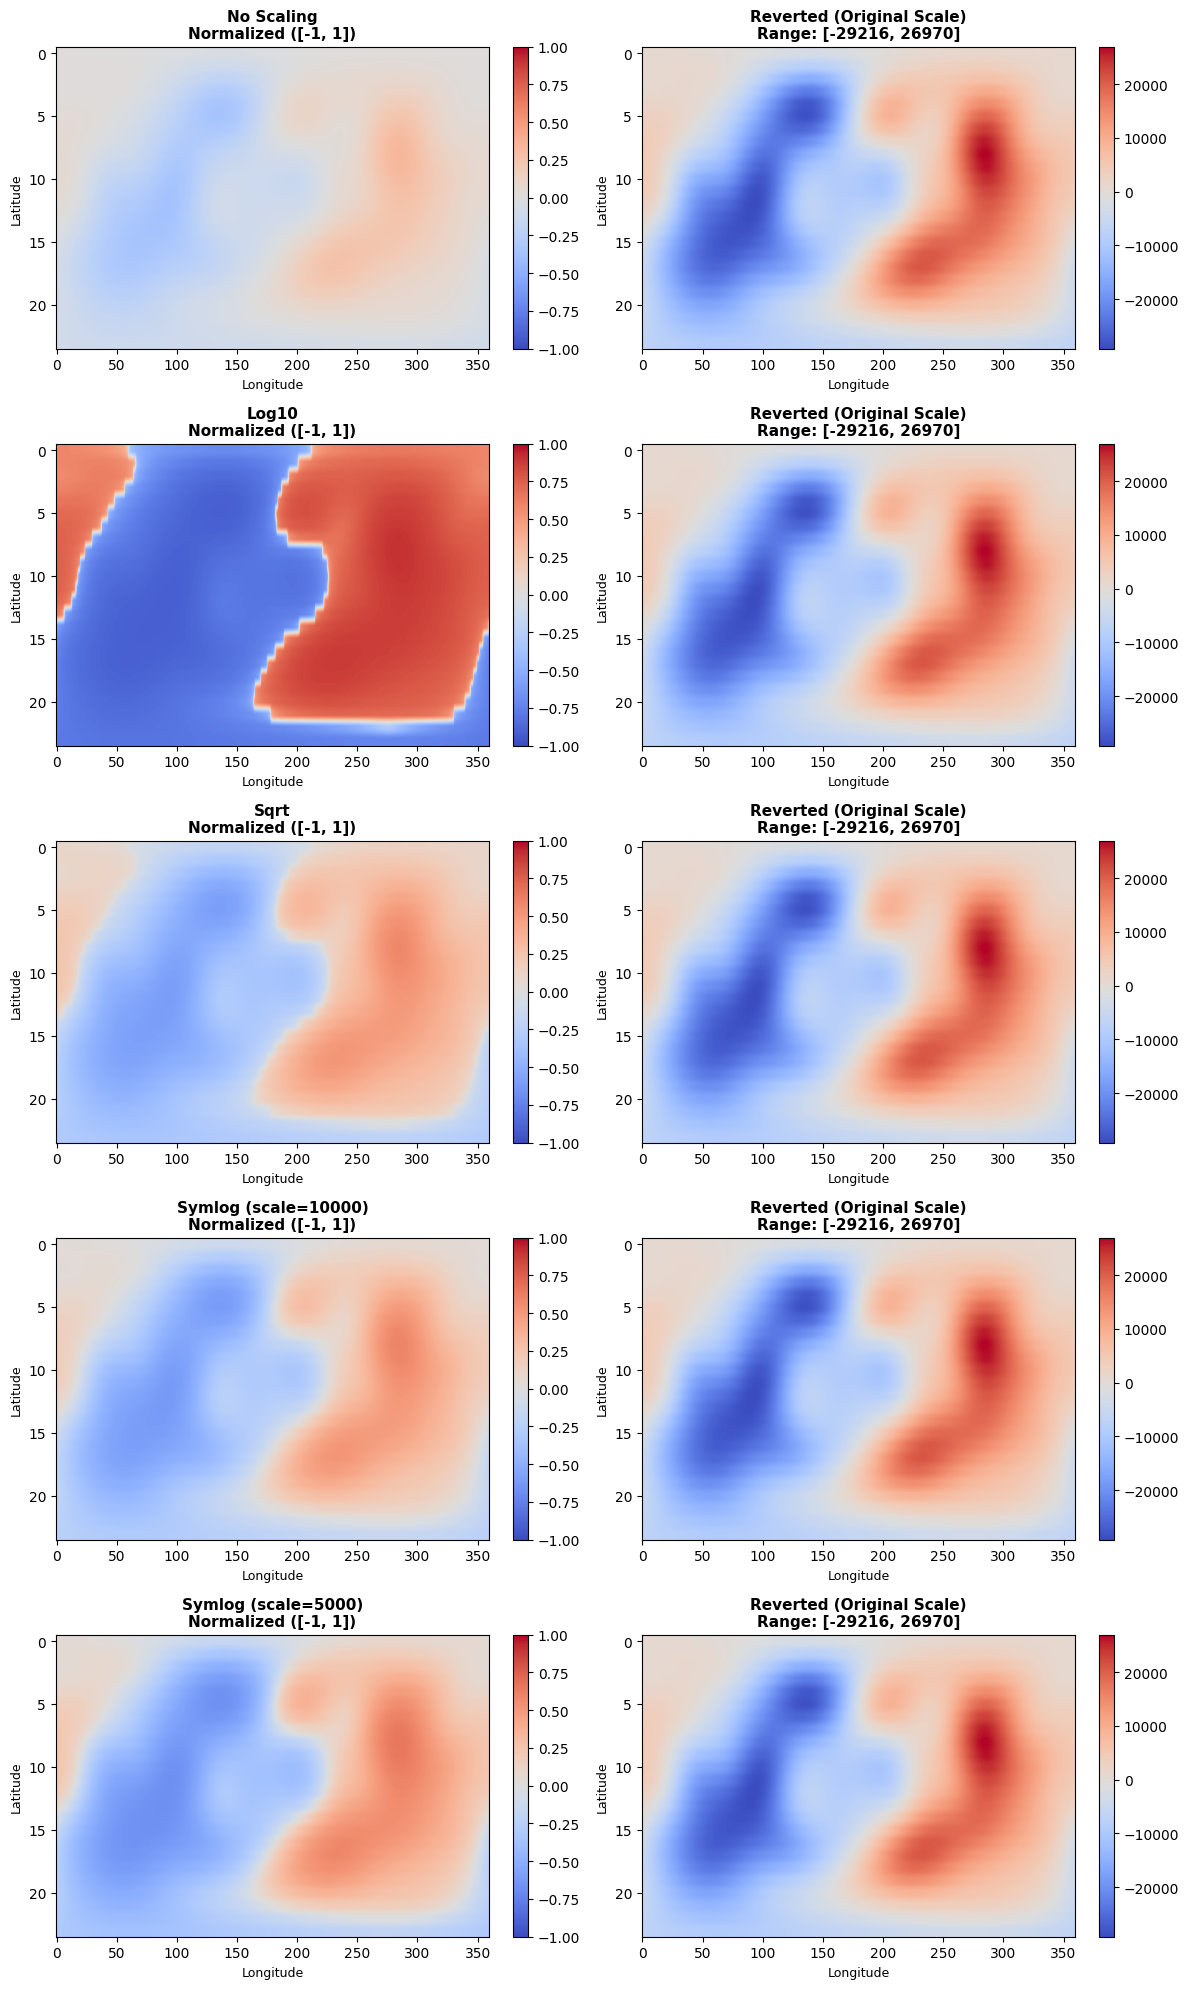

In [6]:
# Visualize normalized and reverted frames for all methods
num_methods = len(samples)
fig, axes = plt.subplots(num_methods, 2, figsize=(12, 4*num_methods))

if num_methods == 1:
    axes = axes.reshape(1, -1)

for i, (name, data) in enumerate(samples.items()):
    # Normalized
    im0 = axes[i, 0].imshow(data['normalized'].numpy(), cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
    axes[i, 0].set_title(f'{name}\nNormalized ([-1, 1])', fontsize=11, fontweight='bold')
    axes[i, 0].set_ylabel('Latitude', fontsize=9)
    axes[i, 0].set_xlabel('Longitude', fontsize=9)
    plt.colorbar(im0, ax=axes[i, 0], fraction=0.046)
    
    # Reverted
    im1 = axes[i, 1].imshow(data['reverted'].numpy(), cmap='coolwarm', aspect='auto')
    axes[i, 1].set_title(f'Reverted (Original Scale)\nRange: [{data["reverted"].min():.0f}, {data["reverted"].max():.0f}]', 
                        fontsize=11, fontweight='bold')
    axes[i, 1].set_ylabel('Latitude', fontsize=9)
    axes[i, 1].set_xlabel('Longitude', fontsize=9)
    plt.colorbar(im1, ax=axes[i, 1], fraction=0.046)

plt.tight_layout()
plt.show()

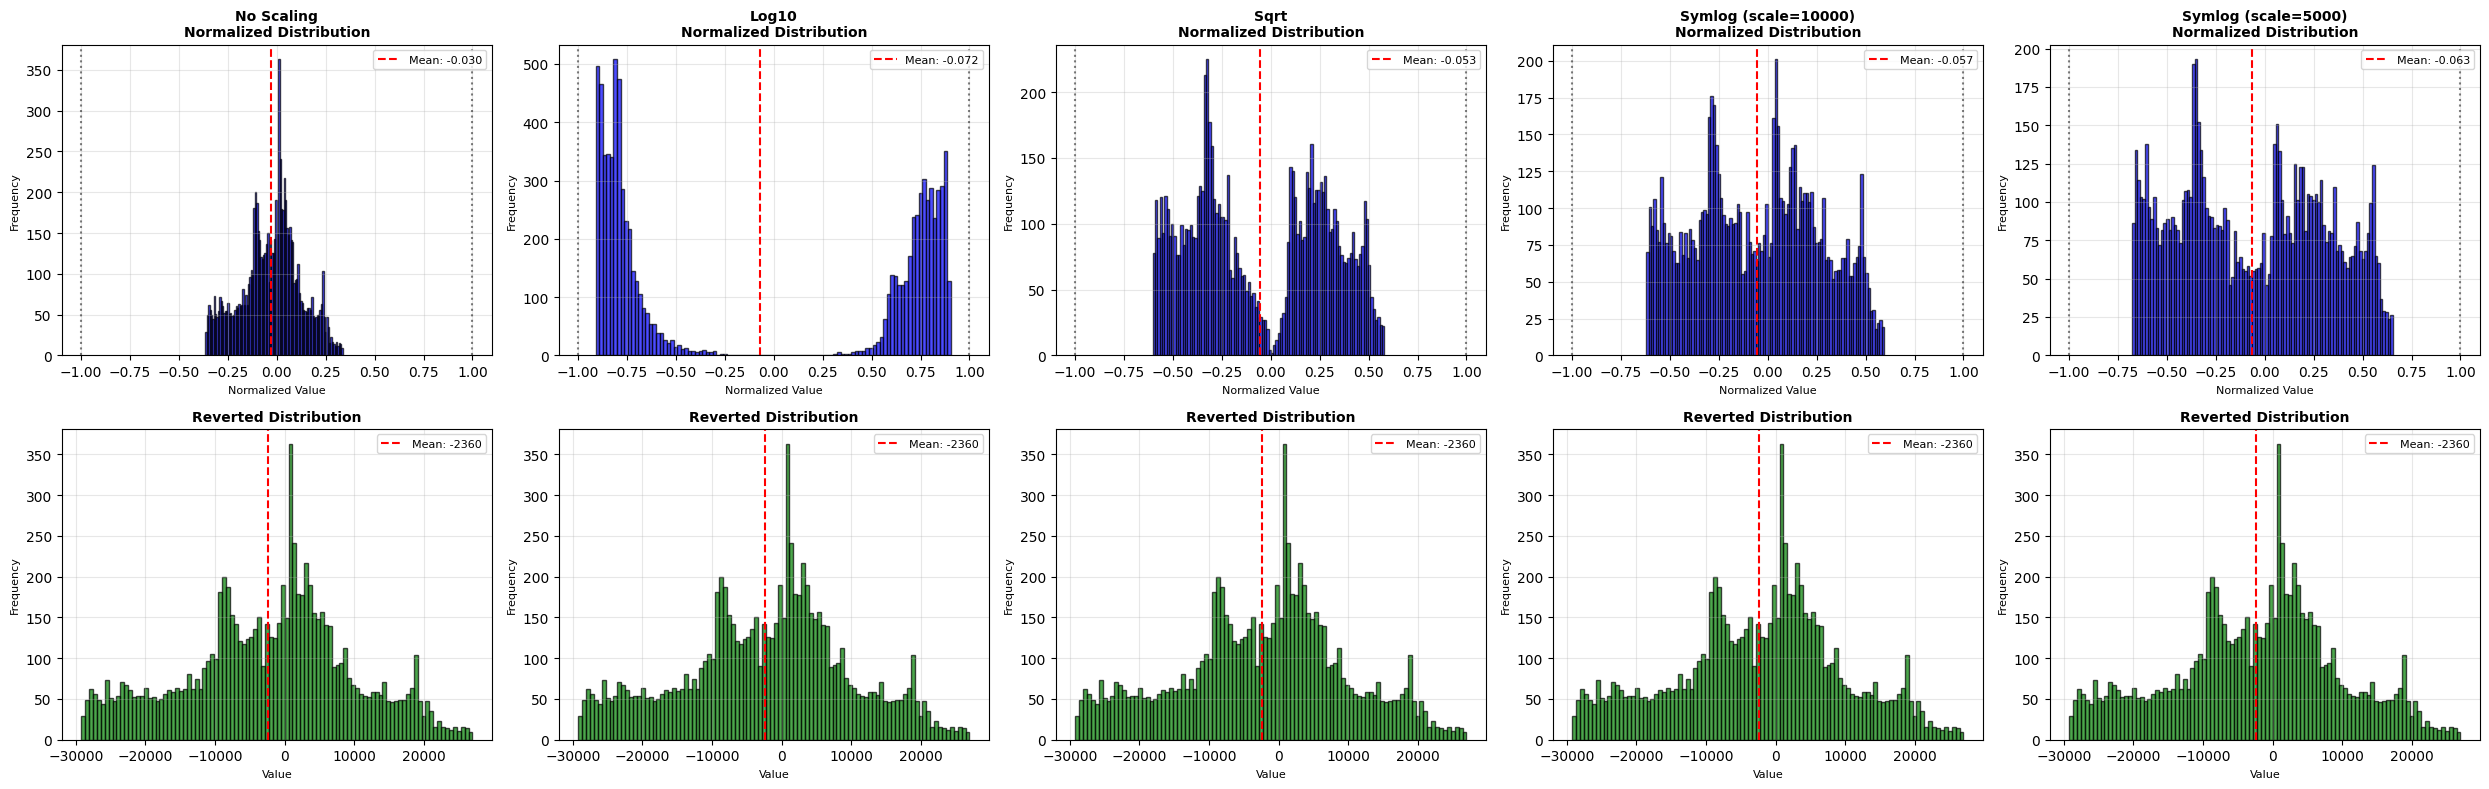

In [7]:
# Plot histograms: Normalized vs Reverted distributions
fig, axes = plt.subplots(2, num_methods, figsize=(5*num_methods, 8))

if num_methods == 1:
    axes = axes.reshape(-1, 1)

# Row 1: Normalized data distribution
for i, (name, data) in enumerate(samples.items()):
    normalized_flat = data['normalized'].flatten().numpy()
    axes[0, i].hist(normalized_flat, bins=100, alpha=0.7, color='blue', edgecolor='black')
    axes[0, i].set_title(f'{name}\nNormalized Distribution', fontsize=10, fontweight='bold')
    axes[0, i].set_xlabel('Normalized Value', fontsize=8)
    axes[0, i].set_ylabel('Frequency', fontsize=8)
    axes[0, i].axvline(normalized_flat.mean(), color='red', linestyle='--', 
                      label=f'Mean: {normalized_flat.mean():.3f}')
    axes[0, i].axvline(-1, color='black', linestyle=':', alpha=0.5)
    axes[0, i].axvline(1, color='black', linestyle=':', alpha=0.5)
    axes[0, i].legend(fontsize=8)
    axes[0, i].grid(True, alpha=0.3)
    axes[0, i].set_xlim(-1.1, 1.1)

# Row 2: Reverted data distribution
for i, (name, data) in enumerate(samples.items()):
    reverted_flat = data['reverted'].flatten().numpy()
    axes[1, i].hist(reverted_flat, bins=100, alpha=0.7, color='green', edgecolor='black')
    axes[1, i].set_title(f'Reverted Distribution', fontsize=10, fontweight='bold')
    axes[1, i].set_xlabel('Value', fontsize=8)
    axes[1, i].set_ylabel('Frequency', fontsize=8)
    axes[1, i].axvline(reverted_flat.mean(), color='red', linestyle='--', 
                      label=f'Mean: {reverted_flat.mean():.0f}')
    axes[1, i].legend(fontsize=8)
    axes[1, i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

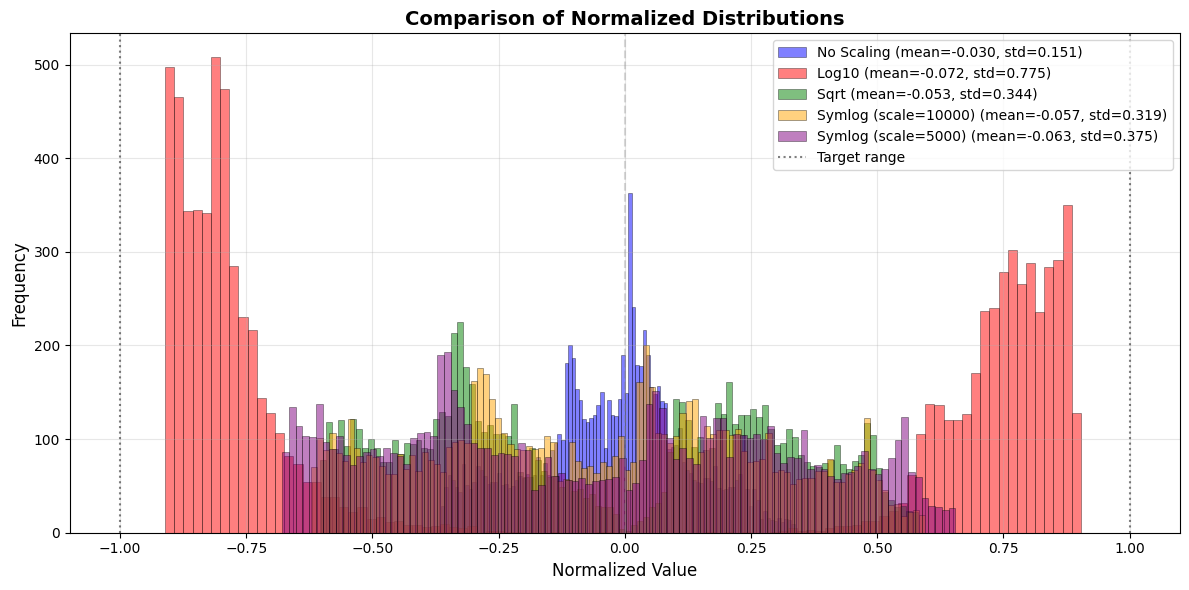

In [8]:
# Overlay all normalized distributions for comparison
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

colors = ['blue', 'red', 'green', 'orange', 'purple']

for i, (name, data) in enumerate(samples.items()):
    normalized_flat = data['normalized'].flatten().numpy()
    ax.hist(normalized_flat, bins=100, alpha=0.5, color=colors[i], 
            label=f'{name} (mean={normalized_flat.mean():.3f}, std={normalized_flat.std():.3f})', 
            edgecolor='black', linewidth=0.5)

ax.set_title('Comparison of Normalized Distributions', fontsize=14, fontweight='bold')
ax.set_xlabel('Normalized Value', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.axvline(-1, color='black', linestyle=':', alpha=0.5, label='Target range')
ax.axvline(1, color='black', linestyle=':', alpha=0.5)
ax.axvline(0, color='gray', linestyle='--', alpha=0.3)
ax.legend(fontsize=10, loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_xlim(-1.1, 1.1)

plt.tight_layout()
plt.show()

In [9]:
# Print detailed statistics
print("="*100)
print("PREPROCESSING METHODS COMPARISON (IonoSequenceDataset)")
print("="*100)
print(f"{'Method':<25s} | {'Norm Min':>10s} | {'Norm Max':>10s} | {'Norm Mean':>10s} | {'Norm Std':>10s}")
print("-"*100)

for name, data in samples.items():
    norm_data = data['normalized'].flatten().numpy()
    print(f"{name:<25s} | {norm_data.min():>10.4f} | {norm_data.max():>10.4f} | "
          f"{norm_data.mean():>10.4f} | {norm_data.std():>10.4f}")

print("="*100)

print("\n" + "="*100)
print("REVERTED DATA STATISTICS")
print("="*100)
print(f"{'Method':<25s} | {'Min':>12s} | {'Max':>12s} | {'Mean':>12s} | {'Std':>12s}")
print("-"*100)

for name, data in samples.items():
    rev_data = data['reverted'].flatten().numpy()
    print(f"{name:<25s} | {rev_data.min():>12.2f} | {rev_data.max():>12.2f} | "
          f"{rev_data.mean():>12.2f} | {rev_data.std():>12.2f}")

print("="*100)

PREPROCESSING METHODS COMPARISON (IonoSequenceDataset)
Method                    |   Norm Min |   Norm Max |  Norm Mean |   Norm Std
----------------------------------------------------------------------------------------------------
No Scaling                |    -0.3652 |     0.3371 |    -0.0295 |     0.1511
Log10                     |    -0.9108 |     0.9037 |    -0.0717 |     0.7753
Sqrt                      |    -0.6043 |     0.5806 |    -0.0531 |     0.3437
Symlog (scale=10000)      |    -0.6219 |     0.5951 |    -0.0565 |     0.3191
Symlog (scale=5000)       |    -0.6788 |     0.6549 |    -0.0633 |     0.3751

REVERTED DATA STATISTICS
Method                    |          Min |          Max |         Mean |          Std
----------------------------------------------------------------------------------------------------
No Scaling                |    -29216.00 |     26970.40 |     -2360.07 |     12089.50
Log10                     |    -29216.01 |     26970.40 |     -2360.07 |     

Sequence shape: torch.Size([1, 30, 1, 24, 360])


/tmp/ipykernel_3300209/956607979.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


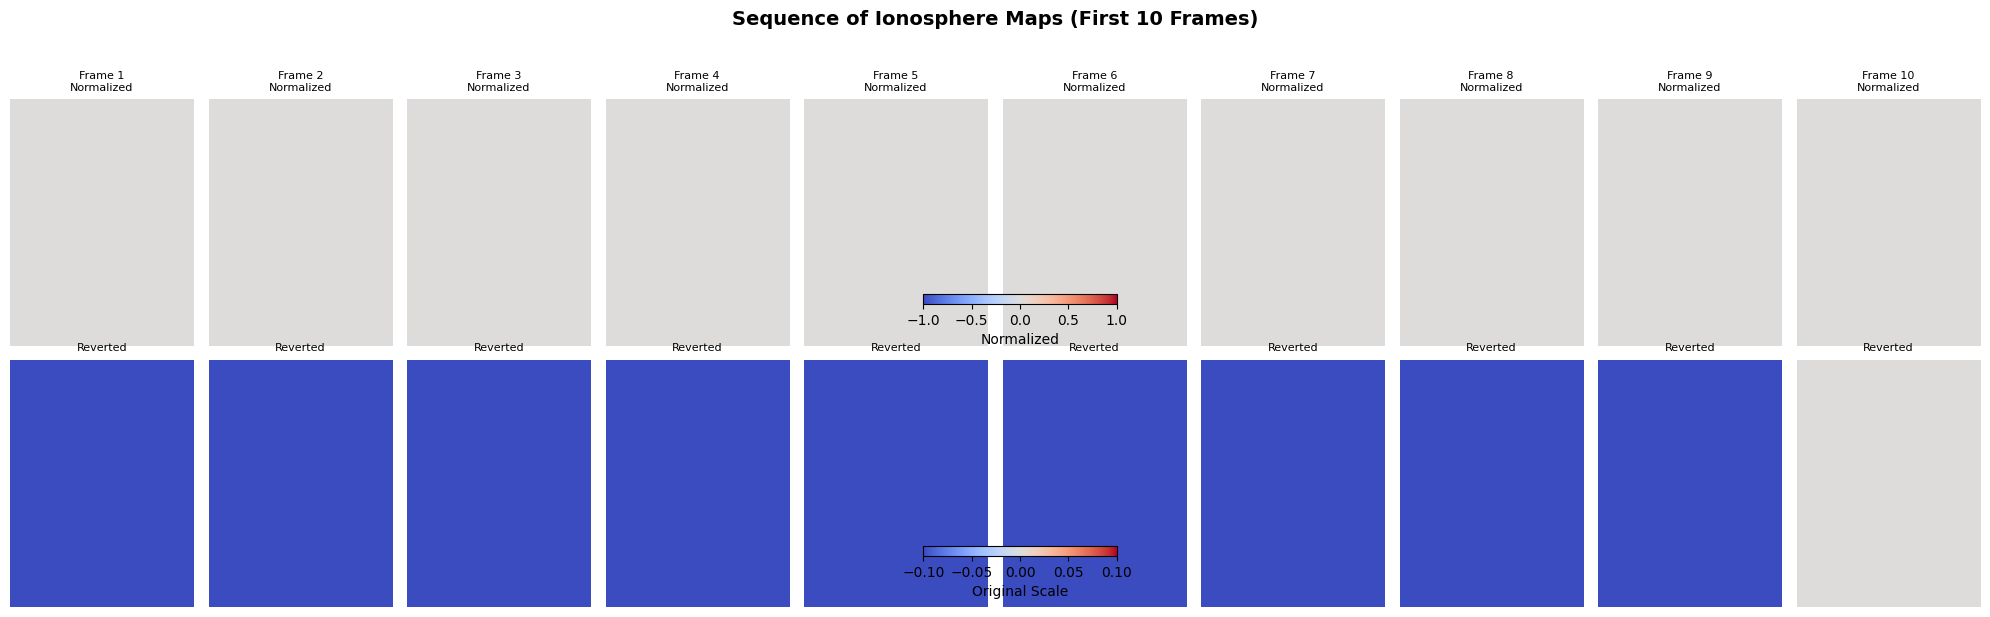

In [10]:
# Test on a full sequence to visualize temporal evolution
# Use the "No Scaling" method
test_dataset = datasets["No Scaling"]['dataset']
test_dataloader = datasets["No Scaling"]['dataloader']

# Get one sequence
data_seq, cond_seq = next(iter(test_dataloader))
print(f"Sequence shape: {data_seq.shape}")  # (batch, time, channels, height, width)

# Plot first 10 frames of the sequence
num_frames = min(10, data_seq.shape[1])
fig, axes = plt.subplots(2, num_frames, figsize=(2*num_frames, 6))

for i in range(num_frames):
    frame_normalized = data_seq[0, i, 0, :, :]
    frame_reverted = test_dataset.reverse_data_normalization(frame_normalized.unsqueeze(0).unsqueeze(0)).squeeze()
    
    # Normalized
    im0 = axes[0, i].imshow(frame_normalized.numpy(), cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
    axes[0, i].set_title(f'Frame {i+1}\nNormalized', fontsize=8)
    axes[0, i].axis('off')
    
    # Reverted
    im1 = axes[1, i].imshow(frame_reverted.numpy(), cmap='coolwarm', aspect='auto')
    axes[1, i].set_title(f'Reverted', fontsize=8)
    axes[1, i].axis('off')

# Add colorbars
fig.colorbar(im0, ax=axes[0, :], orientation='horizontal', fraction=0.046, pad=0.04, label='Normalized')
fig.colorbar(im1, ax=axes[1, :], orientation='horizontal', fraction=0.046, pad=0.04, label='Original Scale')

plt.suptitle('Sequence of Ionosphere Maps (First 10 Frames)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

Testing on 5 random samples...



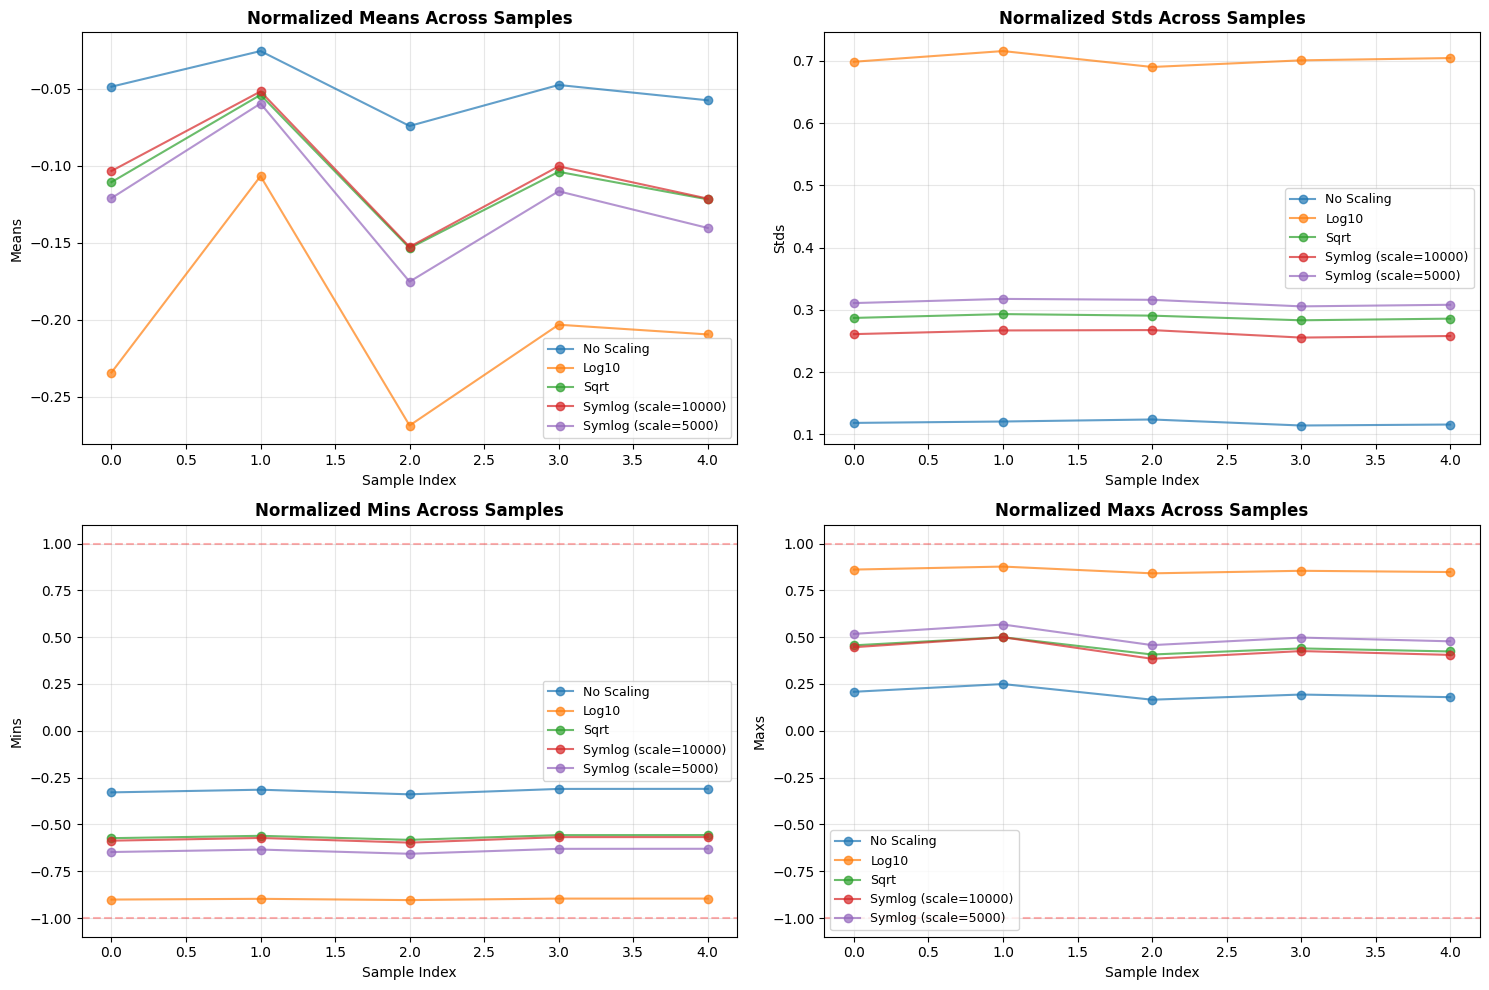


STATISTICS ACROSS MULTIPLE SAMPLES
Method                    |   Avg Mean |    Avg Std |       Min Range |       Max Range
----------------------------------------------------------------------------------------------------
No Scaling                |    -0.0505 |     0.1187 | [-0.340, -0.310] |  [0.166, 0.250]
Log10                     |    -0.2044 |     0.7019 | [-0.904, -0.896] |  [0.841, 0.877]
Sqrt                      |    -0.1086 |     0.2881 | [-0.583, -0.557] |  [0.407, 0.500]
Symlog (scale=10000)      |    -0.1058 |     0.2619 | [-0.597, -0.568] |  [0.385, 0.499]
Symlog (scale=5000)       |    -0.1224 |     0.3118 | [-0.657, -0.630] |  [0.458, 0.568]


In [11]:
# Test on multiple samples to check consistency
num_test_samples = 5
stats_per_method = {name: {'means': [], 'stds': [], 'mins': [], 'maxs': []} 
                    for name in preprocessing_configs.keys()}

print(f"Testing on {num_test_samples} random samples...\n")

for name, ds_dict in datasets.items():
    dataset = ds_dict['dataset']
    
    for sample_idx in range(min(num_test_samples, len(dataset))):
        data_seq, cond_seq = dataset[sample_idx]
        
        # Get middle frame
        frame_idx = data_seq.shape[0] // 2
        normalized_frame = data_seq[frame_idx, 0, :, :]
        norm_flat = normalized_frame.flatten().numpy()
        
        stats_per_method[name]['means'].append(norm_flat.mean())
        stats_per_method[name]['stds'].append(norm_flat.std())
        stats_per_method[name]['mins'].append(norm_flat.min())
        stats_per_method[name]['maxs'].append(norm_flat.max())

# Plot statistics across samples
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for i, (stat_name, ax) in enumerate(zip(['means', 'stds', 'mins', 'maxs'], axes.flatten())):
    for method_name, stats in stats_per_method.items():
        ax.plot(stats[stat_name], 'o-', label=method_name, alpha=0.7)
    
    ax.set_title(f'Normalized {stat_name.capitalize()} Across Samples', fontsize=12, fontweight='bold')
    ax.set_xlabel('Sample Index', fontsize=10)
    ax.set_ylabel(stat_name.capitalize(), fontsize=10)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    
    if stat_name in ['mins', 'maxs']:
        ax.axhline(-1, color='red', linestyle='--', alpha=0.3)
        ax.axhline(1, color='red', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*100)
print("STATISTICS ACROSS MULTIPLE SAMPLES")
print("="*100)
print(f"{'Method':<25s} | {'Avg Mean':>10s} | {'Avg Std':>10s} | {'Min Range':>15s} | {'Max Range':>15s}")
print("-"*100)

for method_name, stats in stats_per_method.items():
    avg_mean = np.mean(stats['means'])
    avg_std = np.mean(stats['stds'])
    min_range = f"[{np.min(stats['mins']):.3f}, {np.max(stats['mins']):.3f}]"
    max_range = f"[{np.min(stats['maxs']):.3f}, {np.max(stats['maxs']):.3f}]"
    
    print(f"{method_name:<25s} | {avg_mean:>10.4f} | {avg_std:>10.4f} | {min_range:>15s} | {max_range:>15s}")

print("="*100)